这是一个用于求解高波数 Helmholtz 方程的混合深度学习框架。
以下是完整的代码结构介绍：

1. 数值求解层：真值数据生成
solve_helmholtz_fd(lam, mu, N)
- 功能：采用有限差分法生成高精度的真值数据。
- 实现细节：
    - 构建三对角稀疏矩阵求解边值问题 u'' + lambda^2 u = sin(mu x)。
    - 返回网格点 x 和对应的数值解 u，用于后续神经网络的训练标签和验证基准。

2. 通用求解器基类：训练框架
Solver(nn.Module, ABC)
- 功能：定义了物理信息神经网络的通用训练流程、数据管理和损失计算。
- 核心组件：
    - 数据初始化：自动调用 solve_helmholtz_fd 生成数据，并采样边界点和内部点。
    - 抽象方法 net_u：定义网络前向传播接口。
    - 物理残差 net_f：利用 PyTorch 自动微分计算 PDE 残差。
    - 双优化器策略 fit：实现动态概率切换机制，交替使用 optimizer_u (拟合数据) 和 optimizer_f (满足物理方程) 进行训练。
    - 评估与可视化：predict 方法用于推理，plot 方法用于绘制结果和损失曲线。

3. 神经网络架构：具体模型实现
这一部分实现了三种不同的神经网络架构，均继承自 Solver 基类。

A. 基础全连接网络
DNNSolver(Solver)
- 架构：标准的深度神经网络。
- 结构：
    - 输入层：接收坐标 x。
    - 隐藏层：由 Linear 层和 Tanh 激活函数交替组成。
    - 输入归一化：在 net_u 中将输入坐标映射到 [-1, 1] 区间。

B. 多尺度傅里叶特征网络
FourierFeatureSolver(Solver)
- 目的：解决神经网络拟合高频信号困难的问题（频谱偏差）。
- 核心组件：
    - MultiScaleFourierLayer：
        - 生成基础频率，并通过 2^k 倍频机制生成多尺度频率。
        - 将原始坐标映射到高维傅里叶特征空间。
        - 引入可学习的权重 beta 和归一化尺度 scale。
- 整体结构：傅里叶特征层 + 多层感知机 (ReLU 激活)。

C. 基于注意力机制的傅里叶网络
AttentionFourierSolver(Solver)
- 目的：利用注意力机制动态融合多尺度特征，增强特征交互。
- 核心组件：
    - MultiScaleFourierLayer：同上，作为特征提取前端。
    - CrossAttentionResidualBlock：
        - 跨注意力机制：将傅里叶特征重塑为 Token 序列。
        - Query-Key 交互：使用可学习的 Query 向量聚合所有特征 Token 的信息。
        - 残差更新：通过多层注意力和非线性激活提炼特征。
- 整体结构：傅里叶特征层 -> 注意力特征融合模块 -> 输出层。



# 必备设置

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from abc import ABC, abstractmethod
import random  

def solve_helmholtz_fd(lam, mu, N=2001):
    """
    使用有限差分法求解Helmholtz方程: u'' + λ²u = sin(μx), u(-1)=u(1)=0
    参数:
        lam: λ参数（波数）
        mu: μ参数（源项频率）
        N: 网格点数（奇数，确保包含x=0）
    返回:
        x: 网格点坐标 [N, 1]
        u: 数值解 [N, 1]
    """
    # 创建网格
    x = np.linspace(-1, 1, N)
    dx = x[1] - x[0]
    
    # 构建系数矩阵 A (三对角矩阵)
    main_diag = (-2/dx**2) + lam**2  # 主对角线
    off_diag = 1/dx**2               # 次对角线
    
    diagonals = [
        np.full(N-1, off_diag),    # 下对角线
        np.full(N, main_diag),     # 主对角线
        np.full(N-1, off_diag)     # 上对角线
    ]
    
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')
    
    # 构建右端项 b = sin(μx)
    b = np.sin(mu * x)
    
    # 应用边界条件 u(-1)=u(1)=0
    A[0, :] = 0
    A[0, 0] = 1
    b[0] = 0
    
    A[-1, :] = 0
    A[-1, -1] = 1
    b[-1] = 0
    
    # 求解线性系统
    u = spsolve(A, b)
    
    return x[:, None], u[:, None]

class Solver(nn.Module, ABC):
    """
    神经网络求解器的抽象类（双优化器 + 动态概率切换）
    """
    def __init__(self, physical_information=False, if_scale_u=False):
        super().__init__()
        self.if_scale_u = if_scale_u
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lam = 205.0
        self.mu = 3.0
        self.lb = -1.0
        self.ub = 1.0
        self.N_fd = 2001
        self.boundary_x = np.array([[-1.0], [1.0]])
        self.boundary_u = np.array([[0.0], [0.0]])
        num_internal_points = 500
        
        # 生成有限差分解
        self.x_fd, self.u_fd = solve_helmholtz_fd(self.lam, self.mu, N=self.N_fd)
        indices = np.linspace(0, len(self.x_fd)-1, num_internal_points, dtype=int)
        internal_x = self.x_fd[indices]
        internal_u = self.u_fd[indices]
        
        # 构建训练点（边界+内部）
        x_u = np.vstack([self.boundary_x, internal_x])
        u = np.vstack([self.boundary_u, internal_u])
        
        # 转换为张量
        self.lb = torch.tensor(self.lb, dtype=torch.float32).to(self.device)
        self.ub = torch.tensor(self.ub, dtype=torch.float32).to(self.device)
        self.x_u = torch.tensor(x_u, dtype=torch.float32).to(self.device)
        self.u = torch.tensor(u, dtype=torch.float32).to(self.device)
        self.scaled_u = self.u * 1e5  # 临时硬编码缩放（建议后续改为自适应）
        
        # 物理信息设置
        self.physical_information = physical_information
        self.x_f = torch.linspace(self.lb, self.ub, 1000).view(-1, 1).to(self.device)
        self.x_f.requires_grad = True
        
        # 双优化器占位符
        self.optimizer_u = None  # 数据拟合优化器
        self.optimizer_f = None  # 物理约束优化器

    @abstractmethod
    def net_u(self, x):
        pass

    def net_f(self, x):
        """计算PDE残差"""
        u = self.net_u(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        if self.if_scale_u:
            return u_xx + (self.lam**2) * u - 1e5 * torch.sin(self.mu * x)
        return u_xx + (self.lam**2) * u - torch.sin(self.mu * x)
    
    def loss(self):
        """分别计算数据损失和物理损失"""
        u_pred = self.net_u(self.x_u)
        loss_u = torch.mean((self.scaled_u - u_pred) ** 2)
        
        if not self.physical_information or not self.training:
            return loss_u, torch.tensor(0.0, device=self.device)
        
        f_pred = self.net_f(self.x_f)
        loss_f = torch.mean(f_pred**2)
        return loss_u, loss_f
    
    def fit(self, nIter, lr=1e-3):
        """双优化器训练（动态概率切换策略）"""
        self.train()
        history = {'total_loss': [], 'loss_u': [], 'loss_f': []}
        
        # 初始化双优化器
        self.optimizer_u = torch.optim.AdamW(self.parameters(), lr=lr)
        self.optimizer_f = torch.optim.AdamW(self.parameters(), lr=lr)
        self.scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_u, mode='min', factor=0.8, patience=200)
        self.scheduler_f = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_f, mode='min', factor=0.9, patience=200)
        for i in range(1, nIter+1):
            # 1. 计算损失
            loss_u, loss_f = self.loss()
            
            # 2. 动态概率切换 
            prob_f =0.4+0.2*(i/nIter)
            use_pde = random.random() < prob_f and self.physical_information
            
            # 3. 选择性优化
            if use_pde:
                self.optimizer_f.zero_grad()
                loss_f.backward()
                self.optimizer_f.step()
                self.scheduler_f.step(loss_f.item())
            else:
                self.optimizer_u.zero_grad()
                loss_u.backward()
                self.optimizer_u.step()
                self.scheduler_u.step(loss_u.item())
            
            # 4. 记录历史
            total_loss = loss_u.detach() + loss_f.detach()
            history['total_loss'].append(total_loss.item())
            history['loss_u'].append(loss_u.item())
            history['loss_f'].append(loss_f.item())
            
            # 5. 定期输出
            if (i+1) % 500 == 0:
                print(f'Iter {i+1}/{nIter} | Total: {total_loss.item():.3e} | Data: {loss_u.item():.3e} | PDE: {loss_f.item():.3e} | PDE Prob: {prob_f:.2f}')
        
        self.plot(history)
        return history
    
    def predict(self, x):
        """预测结果（自动处理缩放）"""
        self.eval()
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            u_pred = self.net_u(x_tensor)
        return u_pred.cpu().numpy() * 1e-5 if self.if_scale_u else u_pred.cpu().numpy()
        
    def plot(self, history):
        """绘制预测结果和训练历史"""
        u_pred = self.predict(self.x_fd)
        
        # 创建结果图
        plt.figure(figsize=(12, 10))
        plt.plot(self.x_fd, self.u_fd, 'k-', label='Finite Difference Solution', linewidth=2)
        plt.plot(self.x_fd, u_pred, 'b--', label='DNN Prediction', linewidth=2)
        plt.scatter(self.x_u.detach().cpu().numpy(), 
                   self.u.detach().cpu().numpy(), 
                   color='red', s=20, zorder=5, label='Training Points')
        plt.xlabel('x', fontsize=14)
        plt.ylabel('u(x)', fontsize=14)
        title = f'Helmholtz Equation Solution: λ={self.lam}, μ={self.mu}'
        if self.physical_information:
            title += ' (Physics-Informed)'
        else:
            title += ' (Data-Driven)'
        plt.title(title, fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # 创建损失历史图
        plt.figure(figsize=(10, 6))
        if self.physical_information:
            plt.semilogy(history['total_loss'], 'k-', label='Total Loss', linewidth=2)
            plt.semilogy(history['loss_u'], 'b--', label='Data Loss (Loss_u)', linewidth=2)
            plt.semilogy(history['loss_f'], 'r-.', label='Physics Loss (Loss_f)', linewidth=2)
        else:
            plt.semilogy(history['total_loss'], 'k-', label='Loss', linewidth=2)
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Loss (log scale)', fontsize=14)
        plt.title('Training Loss History', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # 计算并显示误差统计
        if self.physical_information:
            with torch.no_grad():
                error = np.abs(u_pred - self.u_fd)
                max_error = np.max(error)
                mean_error = np.mean(error)
                print(f"Maximum absolute error: {max_error:.3e}")
                print(f"Mean absolute error: {mean_error:.3e}")

# 简单DNN

In [10]:
class DNNSolver(Solver):
    def __init__(self,layers):
        super().__init__()
        modules=[]
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i],layers[i+1]))
            if i<len(layers)-2:
                modules.append(nn.Tanh())
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_norm=2.0*(x-self.lb)/(self.ub-self.lb)-1.0
        u=self.net(x_norm)
        return u

Iter 500/10000 | Total: 3.047e-01 | Data: 3.047e-01 | PDE: 0.000e+00 | PDE Prob: 0.41
Iter 1000/10000 | Total: 6.942e-02 | Data: 6.942e-02 | PDE: 0.000e+00 | PDE Prob: 0.42
Iter 1500/10000 | Total: 6.788e-02 | Data: 6.788e-02 | PDE: 0.000e+00 | PDE Prob: 0.43
Iter 2000/10000 | Total: 6.762e-02 | Data: 6.762e-02 | PDE: 0.000e+00 | PDE Prob: 0.44
Iter 2500/10000 | Total: 6.754e-02 | Data: 6.754e-02 | PDE: 0.000e+00 | PDE Prob: 0.45
Iter 3000/10000 | Total: 6.750e-02 | Data: 6.750e-02 | PDE: 0.000e+00 | PDE Prob: 0.46
Iter 3500/10000 | Total: 6.747e-02 | Data: 6.747e-02 | PDE: 0.000e+00 | PDE Prob: 0.47
Iter 4000/10000 | Total: 6.745e-02 | Data: 6.745e-02 | PDE: 0.000e+00 | PDE Prob: 0.48
Iter 4500/10000 | Total: 6.747e-02 | Data: 6.747e-02 | PDE: 0.000e+00 | PDE Prob: 0.49
Iter 5000/10000 | Total: 6.741e-02 | Data: 6.741e-02 | PDE: 0.000e+00 | PDE Prob: 0.50
Iter 5500/10000 | Total: 6.740e-02 | Data: 6.740e-02 | PDE: 0.000e+00 | PDE Prob: 0.51
Iter 6000/10000 | Total: 6.739e-02 | Data: 6

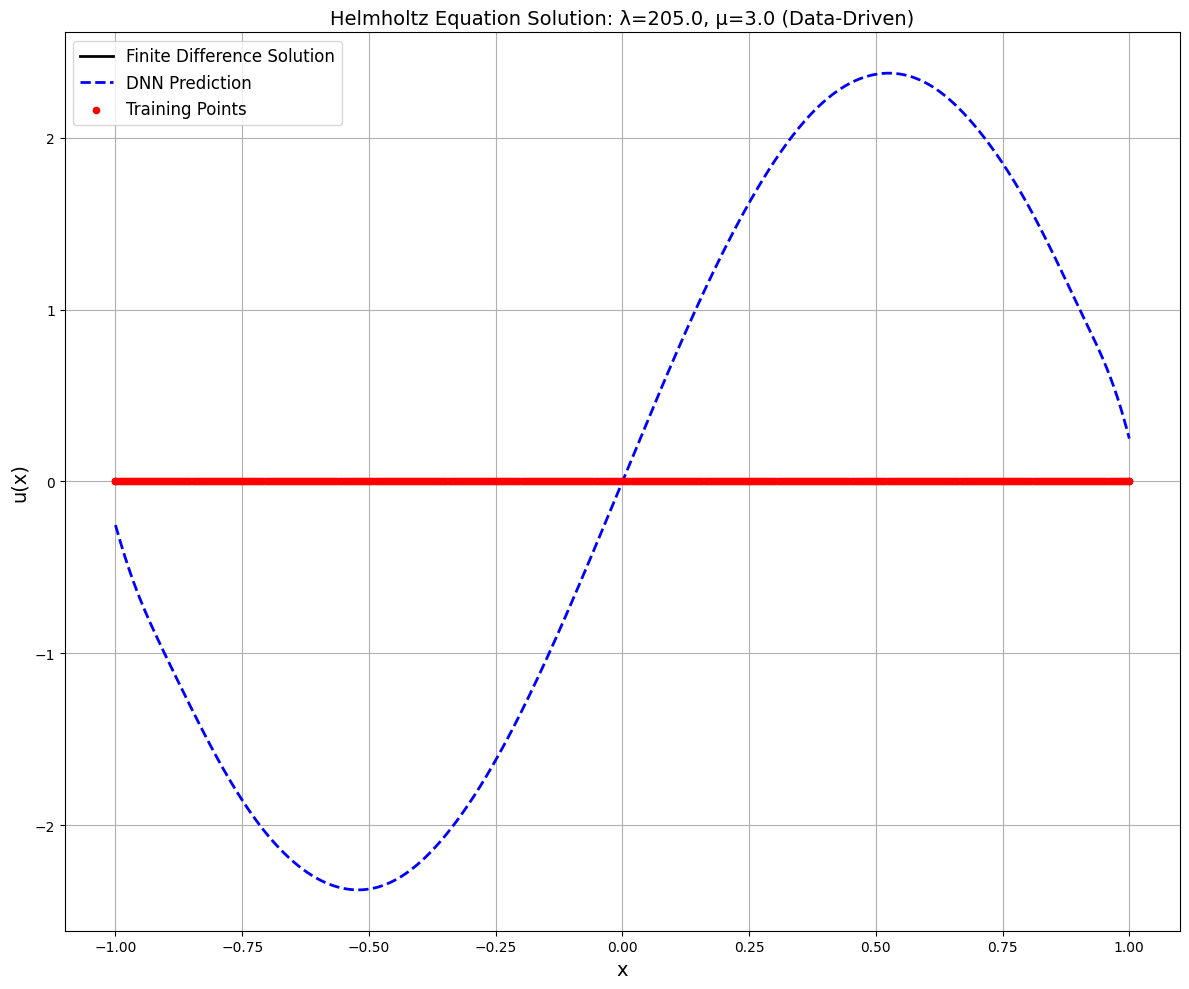

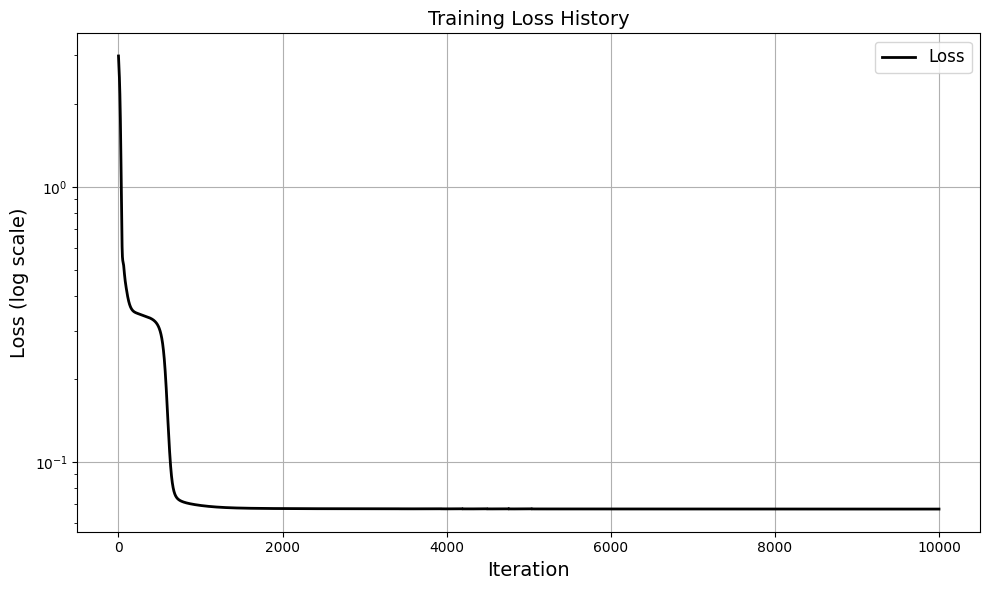

In [11]:
layers=[1,16,32,32,16,1]
dnn_solver=DNNSolver(layers)
dnn_solver.if_scale_u=False 
dnn_solver.physical_information=False
history=dnn_solver.fit(10000)

Iter 500/10000 | Total: 7.818e-02 | Data: 7.818e-02 | PDE: 0.000e+00 | PDE Prob: 0.41
Iter 1000/10000 | Total: 6.847e-02 | Data: 6.847e-02 | PDE: 0.000e+00 | PDE Prob: 0.42
Iter 1500/10000 | Total: 6.778e-02 | Data: 6.778e-02 | PDE: 0.000e+00 | PDE Prob: 0.43
Iter 2000/10000 | Total: 6.758e-02 | Data: 6.758e-02 | PDE: 0.000e+00 | PDE Prob: 0.44
Iter 2500/10000 | Total: 6.751e-02 | Data: 6.751e-02 | PDE: 0.000e+00 | PDE Prob: 0.45
Iter 3000/10000 | Total: 6.748e-02 | Data: 6.748e-02 | PDE: 0.000e+00 | PDE Prob: 0.46
Iter 3500/10000 | Total: 6.746e-02 | Data: 6.746e-02 | PDE: 0.000e+00 | PDE Prob: 0.47
Iter 4000/10000 | Total: 6.744e-02 | Data: 6.744e-02 | PDE: 0.000e+00 | PDE Prob: 0.48
Iter 4500/10000 | Total: 6.742e-02 | Data: 6.742e-02 | PDE: 0.000e+00 | PDE Prob: 0.49
Iter 5000/10000 | Total: 6.740e-02 | Data: 6.740e-02 | PDE: 0.000e+00 | PDE Prob: 0.50
Iter 5500/10000 | Total: 6.738e-02 | Data: 6.738e-02 | PDE: 0.000e+00 | PDE Prob: 0.51
Iter 6000/10000 | Total: 6.736e-02 | Data: 6

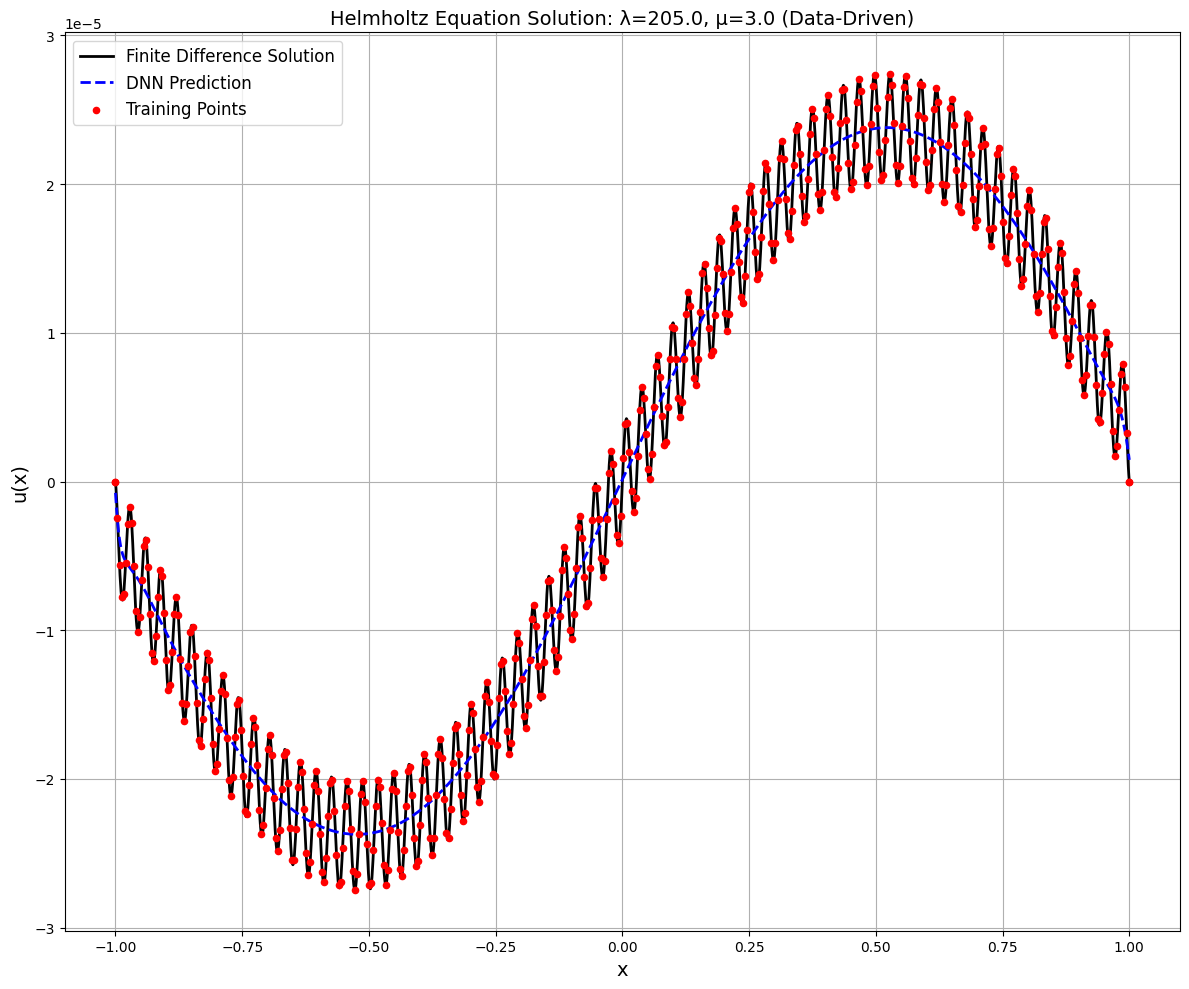

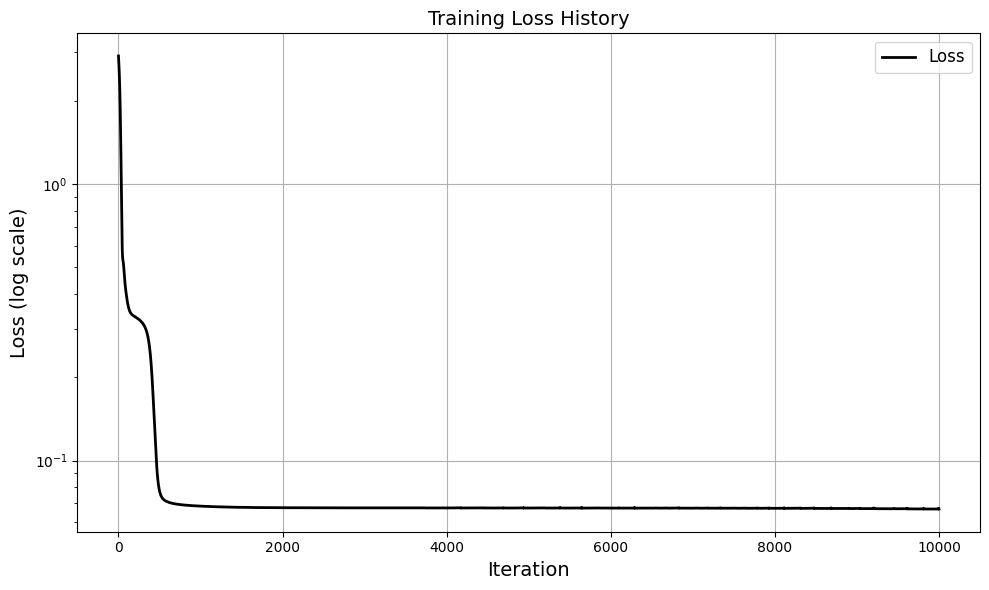

In [ ]:
layers=[1,16,32,32,16,1]
dnn_solver=DNNSolver(layers)
dnn_solver.if_scale_u=True 
dnn_solver.physical_information=False
history=dnn_solver.fit(10000)

# 加入随机傅里叶特征

In [ ]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        base_freqs=(torch.rand(self.base_feature_dim,input_dim)-0.5)*2.0*np.pi
        all_freqs=[]
        for feature in base_freqs:
            for k in range(1,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        self.register_buffer('omega',torch.tensor(all_freqs).reshape(-1,input_dim).float())
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega}")
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi
        self.register_buffer('phases',phases)
        with torch.no_grad():
            beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)
        self.beta=nn.Parameter(beta)
        self.scale=torch.sqrt(torch.tensor(2.0/self.total_feature_dim,dtype=torch.float32))
    def forward(self, x):
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * self.beta
        return features
class FourierFeatureSolver(Solver):
    def __init__(self,layers,base_feature_dim,num_scales):
        super().__init__()
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=1,base_feature_dim=base_feature_dim,num_scales=num_scales)
        input_dim=self.multi_scale_fourier_layer.total_feature_dim
        modules=[]
        modules.append(nn.Linear(input_dim,layers[0]))
        for i in range(0,len(layers)-1):
            modules.append(nn.ReLU())
            modules.append(nn.Linear(layers[i],layers[i+1]))
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_features=self.multi_scale_fourier_layer(x)
        u=self.net(x_features)
        return u

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_12608\1453690804.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[ 3.7530e+00],
        [ 7.5060e+00],
        [ 1.5012e+01],
        [ 3.0024e+01],
        [ 6.0048e+01],
        [ 1.2010e+02],
        [ 2.4019e+02],
        [ 4.8038e+02],
        [ 5.7869e+00],
        [ 1.1574e+01],
        [ 2.3148e+01],
        [ 4.6295e+01],
        [ 9.2590e+01],
        [ 1.8518e+02],
        [ 3.7036e+02],
        [ 7.4072e+02],
        [-6.9855e-02],
        [-1.3971e-01],
        [-2.7942e-01],
        [-5.5884e-01],
        [-1.1177e+00],
        [-2.2354e+00],
        [-4.4707e+00],
        [-8.9415e+00],
        [ 2.8199e+00],
        [ 5.6398e+00],
        [ 1.1280e+01],
        [ 2.2559e+01],
        [ 4.5119e+01],
        [ 9.0237e+01],
        [ 1.8047e+02],
        [ 3.6095e+02],
        [ 5.2777e-01],
        [ 1.0555e+00],
        [ 2.1111e+00],
        [ 4.2222e+00],
        [ 8.4443e+00],
        [ 1.6889e+01],
        [ 3.3777e+01],
        [ 6.7555e+01],
        [ 4.0453e+00],
 

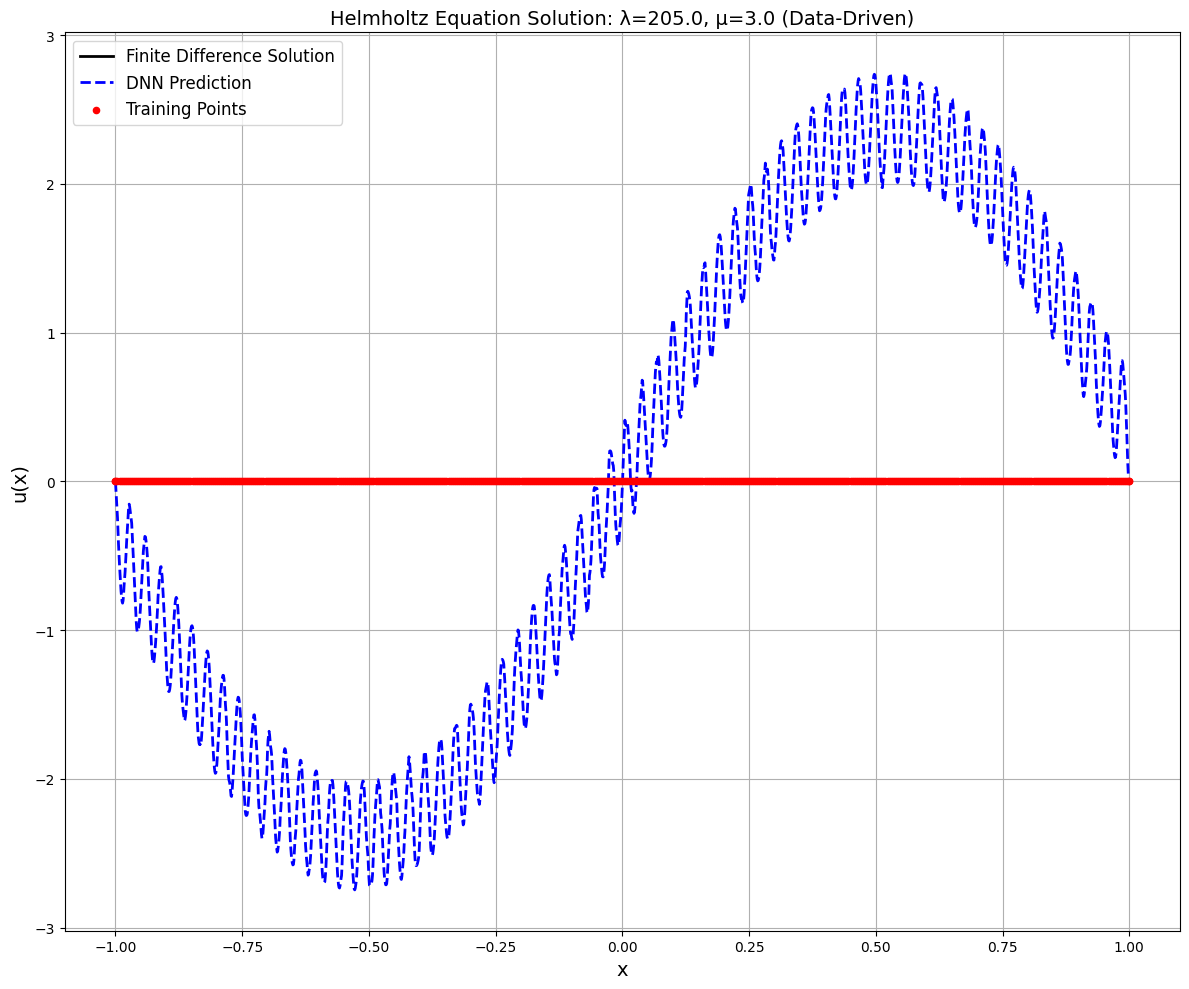

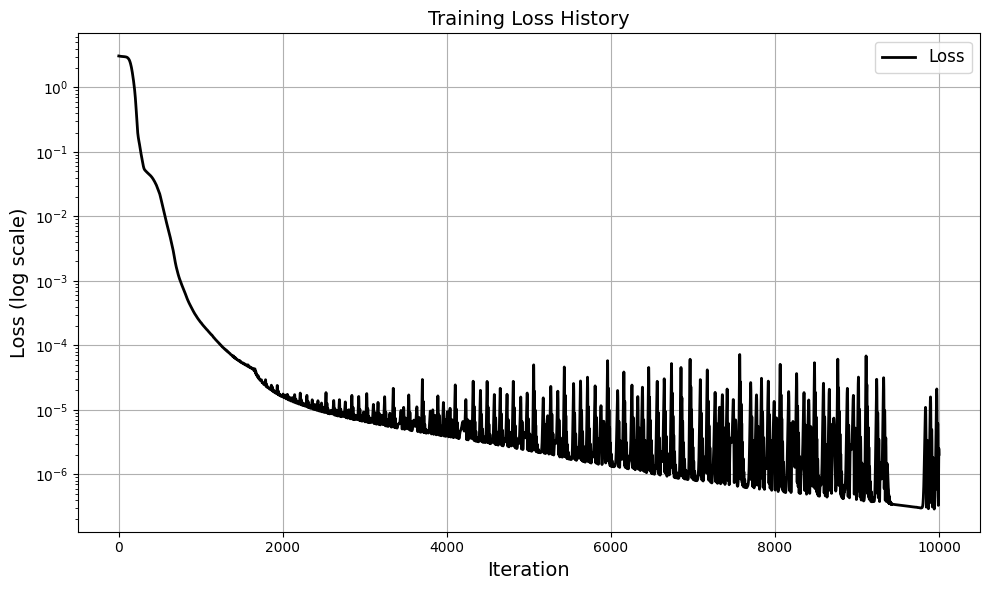

In [ ]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.if_scale_u=False
fourier_solver.physical_information=False
history=fourier_solver.fit(10000)

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_16776\1453690804.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[ 5.9059e+00],
        [ 1.1812e+01],
        [ 2.3624e+01],
        [ 4.7247e+01],
        [ 9.4495e+01],
        [ 1.8899e+02],
        [ 3.7798e+02],
        [ 7.5596e+02],
        [ 6.0419e+00],
        [ 1.2084e+01],
        [ 2.4168e+01],
        [ 4.8335e+01],
        [ 9.6670e+01],
        [ 1.9334e+02],
        [ 3.8668e+02],
        [ 7.7336e+02],
        [-3.2639e+00],
        [-6.5279e+00],
        [-1.3056e+01],
        [-2.6112e+01],
        [-5.2223e+01],
        [-1.0445e+02],
        [-2.0889e+02],
        [-4.1778e+02],
        [-1.7228e+00],
        [-3.4457e+00],
        [-6.8914e+00],
        [-1.3783e+01],
        [-2.7565e+01],
        [-5.5131e+01],
        [-1.1026e+02],
        [-2.2052e+02],
        [ 1.9001e-01],
        [ 3.8002e-01],
        [ 7.6003e-01],
        [ 1.5201e+00],
        [ 3.0401e+00],
        [ 6.0803e+00],
        [ 1.2161e+01],
        [ 2.4321e+01],
        [ 1.8032e+00],
 

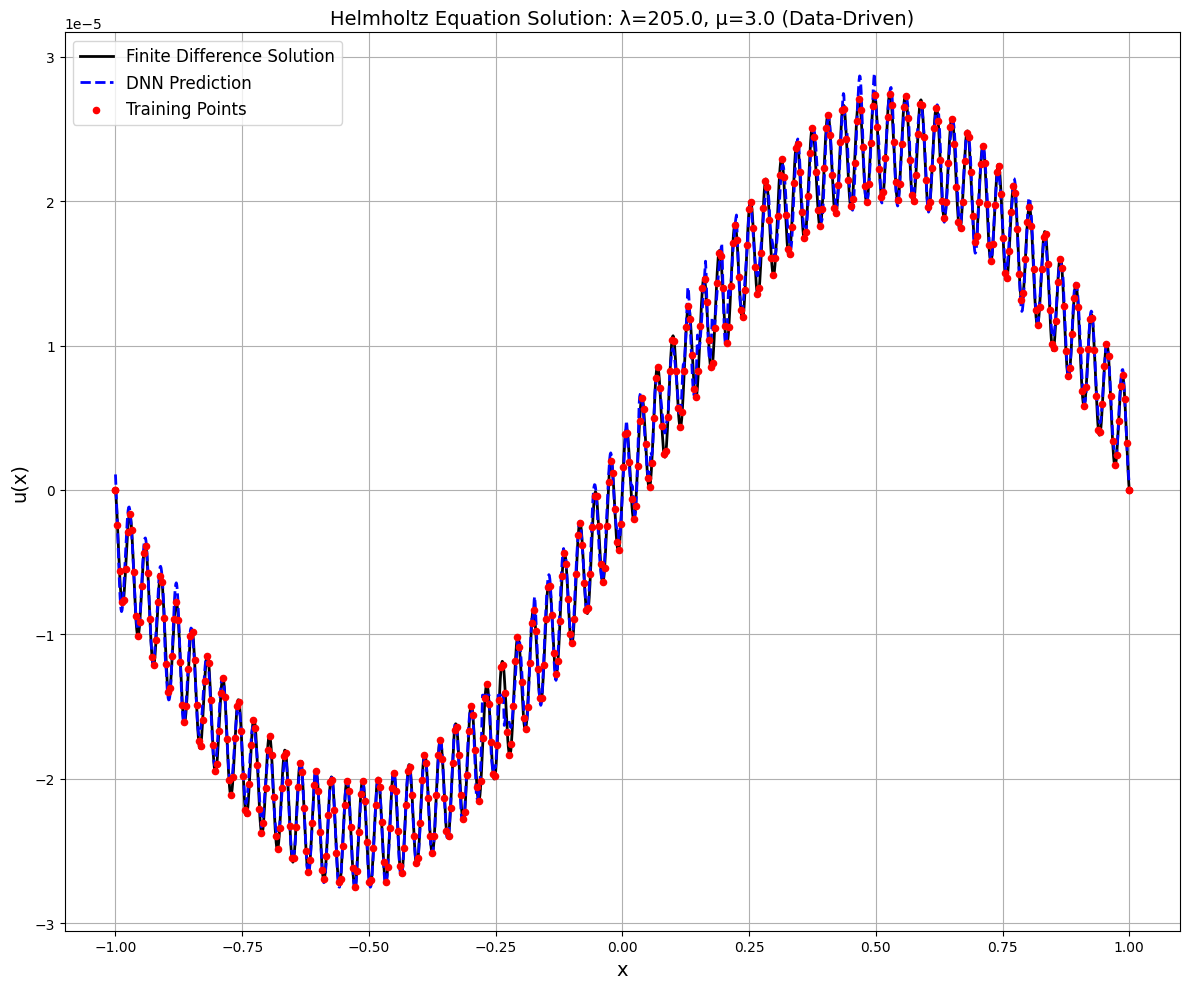

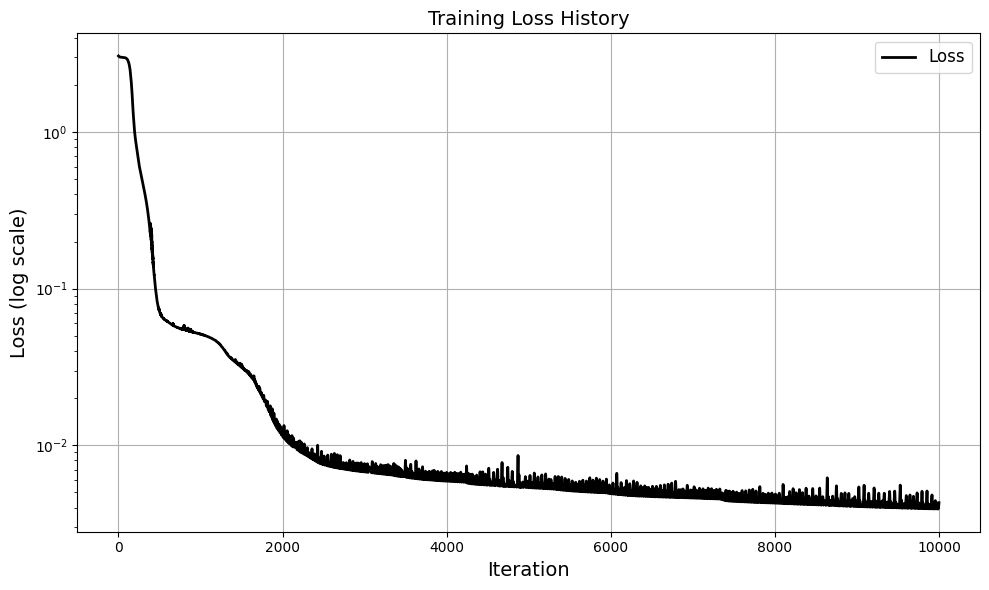

In [ ]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.if_scale_u=True
fourier_solver.physical_information=False
history=fourier_solver.fit(10000)

# 加入物理信息

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_12608\1453690804.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[-3.4181e+00],
        [-6.8363e+00],
        [-1.3673e+01],
        [-2.7345e+01],
        [-5.4690e+01],
        [-1.0938e+02],
        [-2.1876e+02],
        [-4.3752e+02],
        [ 3.6824e+00],
        [ 7.3647e+00],
        [ 1.4729e+01],
        [ 2.9459e+01],
        [ 5.8918e+01],
        [ 1.1784e+02],
        [ 2.3567e+02],
        [ 4.7134e+02],
        [-2.9693e+00],
        [-5.9386e+00],
        [-1.1877e+01],
        [-2.3754e+01],
        [-4.7509e+01],
        [-9.5017e+01],
        [-1.9003e+02],
        [-3.8007e+02],
        [-2.4320e+00],
        [-4.8640e+00],
        [-9.7281e+00],
        [-1.9456e+01],
        [-3.8912e+01],
        [-7.7824e+01],
        [-1.5565e+02],
        [-3.1130e+02],
        [ 2.8099e+00],
        [ 5.6198e+00],
        [ 1.1240e+01],
        [ 2.2479e+01],
        [ 4.4958e+01],
        [ 8.9917e+01],
        [ 1.7983e+02],
        [ 3.5967e+02],
        [ 4.7441e+00],
 

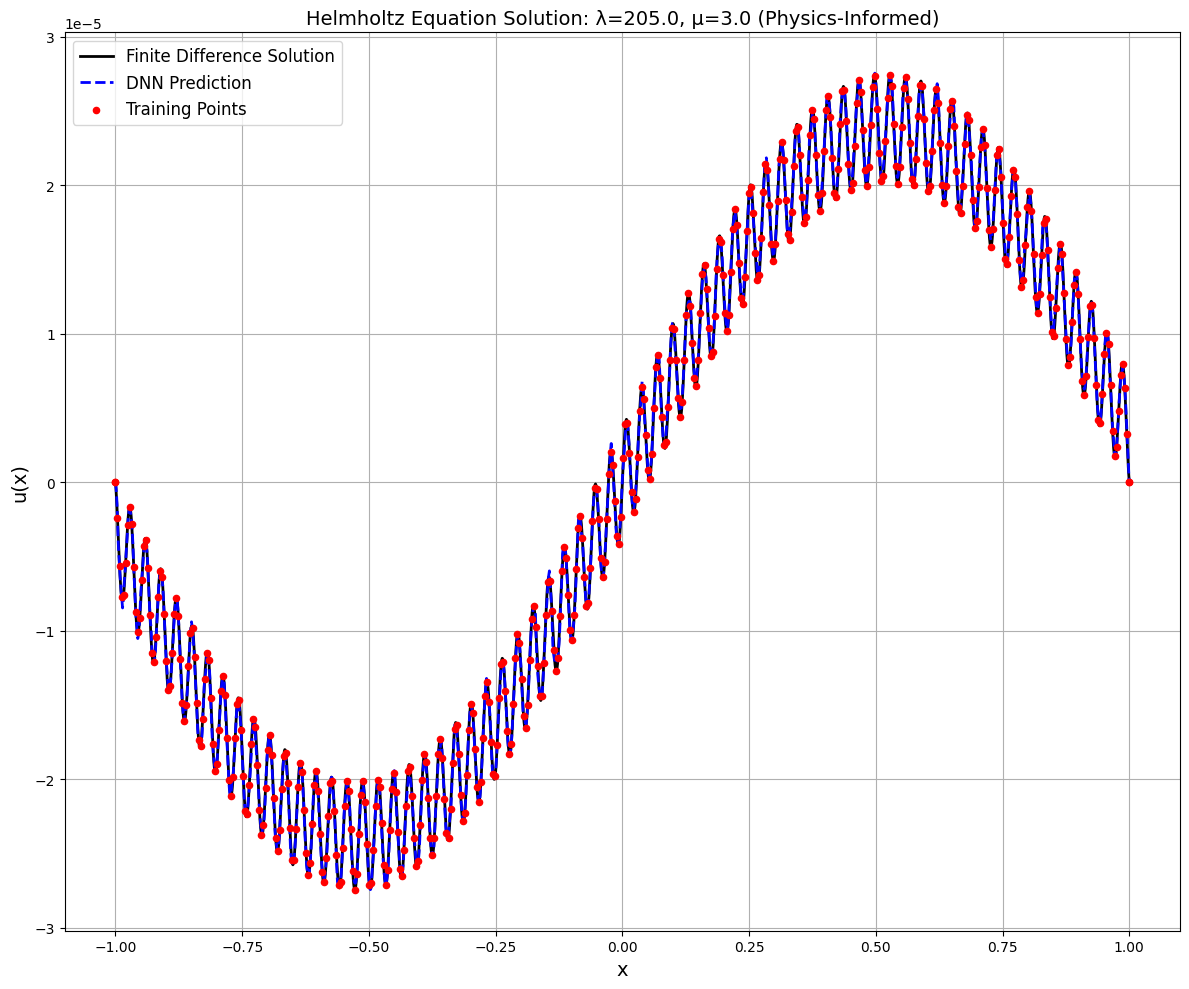

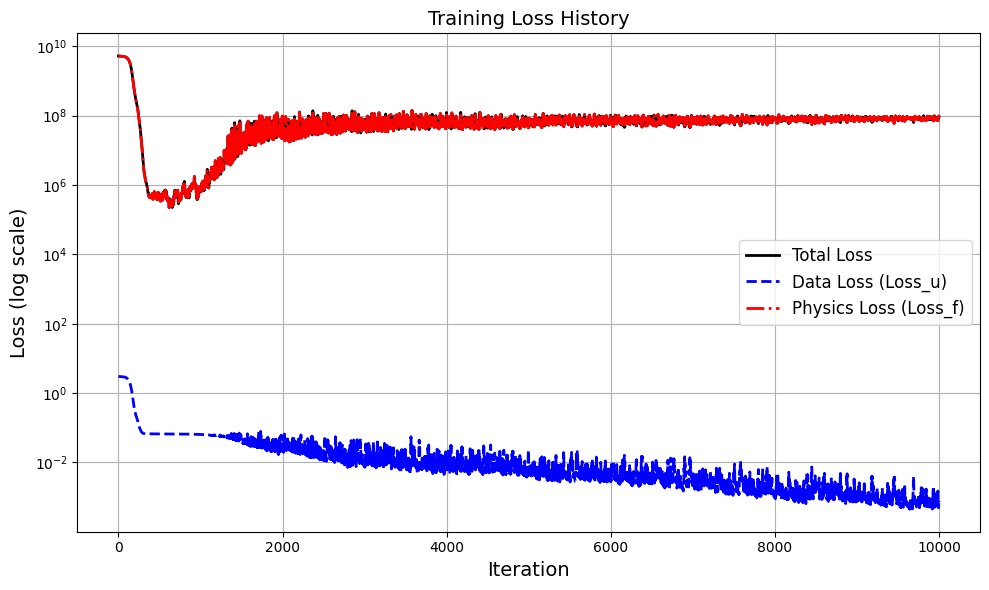

Maximum absolute error: 1.212e-06
Mean absolute error: 2.336e-07


In [ ]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.physical_information=True
fourier_solver.if_scale_u=True
history=fourier_solver.fit(10000)

In [ ]:
class CrossAttentionResidualBlock(nn.Module):
    def __init__(self,N_tok,d_q,num_layers):
        super().__init__()
        self.N_tok=N_tok
        self.d_q=d_q
        self.M = N_tok * d_q
        self.num_layers = num_layers
        self.initial_fc=nn.Sequential(
            nn.Linear(self.M,d_q),
            nn.ReLU()
        )
        self.W_Q = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_K = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_V = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.update_fc=nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_q, d_q),
                nn.ReLU()
            ) for _ in range(num_layers)
        ])
        self.scale=1.0/np.sqrt(d_q)
    
    def forward(self,phi):
        batch_size=phi.shape[0]
        assert phi.shape[1]==self.M, f"Input feature dimension {phi.shape[1]} does not match expected {self.M}"
        H=phi.reshape(batch_size,self.N_tok,self.d_q)
        Q=self.initial_fc(phi)
        for i in range(self.num_layers):
            Q_i=self.W_Q[i](Q)
            K_i=self.W_K[i](H)
            V_i=self.W_V[i](H)
            Q_expanded=Q_i.unsqueeze(1)
            attn_scores=torch.matmul(Q_expanded,K_i.transpose(1,2))*self.scale
            attn_weights=torch.softmax(attn_scores,dim=-1)
            attn_output=torch.matmul(attn_weights,V_i).squeeze(1)
            Q=Q+attn_output
            Q=self.update_fc[i](Q)
        return Q
    
class AttentionFourierSolver(Solver):
    def __init__(self,input_dim,base_feature_dim,num_scales,N_tok,d_q,num_attn_layers):
        super().__init__()
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=input_dim,base_feature_dim=base_feature_dim,num_scales=num_scales)
        self.cross_attention_residual_block=CrossAttentionResidualBlock(N_tok,d_q,num_attn_layers)
        self.output_layer=nn.Linear(d_q,1)
        self.to(self.device)

    def net_u(self,x):
        x_features=self.multi_scale_fourier_layer(x)
        attn_output=self.cross_attention_residual_block(x_features)
        u=self.output_layer(attn_output)
        return u

# 加入attention机制(无物理信息)

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_16776\1453690804.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[ 2.9912e+00],
        [ 5.9823e+00],
        [ 1.1965e+01],
        [ 2.3929e+01],
        [ 4.7859e+01],
        [ 9.5717e+01],
        [ 1.9143e+02],
        [ 3.8287e+02],
        [ 1.2204e+00],
        [ 2.4409e+00],
        [ 4.8817e+00],
        [ 9.7634e+00],
        [ 1.9527e+01],
        [ 3.9054e+01],
        [ 7.8107e+01],
        [ 1.5621e+02],
        [-4.5707e+00],
        [-9.1413e+00],
        [-1.8283e+01],
        [-3.6565e+01],
        [-7.3131e+01],
        [-1.4626e+02],
        [-2.9252e+02],
        [-5.8505e+02],
        [-1.3299e+00],
        [-2.6597e+00],
        [-5.3194e+00],
        [-1.0639e+01],
        [-2.1278e+01],
        [-4.2556e+01],
        [-8.5111e+01],
        [-1.7022e+02],
        [ 2.2255e+00],
        [ 4.4510e+00],
        [ 8.9019e+00],
        [ 1.7804e+01],
        [ 3.5608e+01],
        [ 7.1215e+01],
        [ 1.4243e+02],
        [ 2.8486e+02],
        [-6.9300e-01],
 

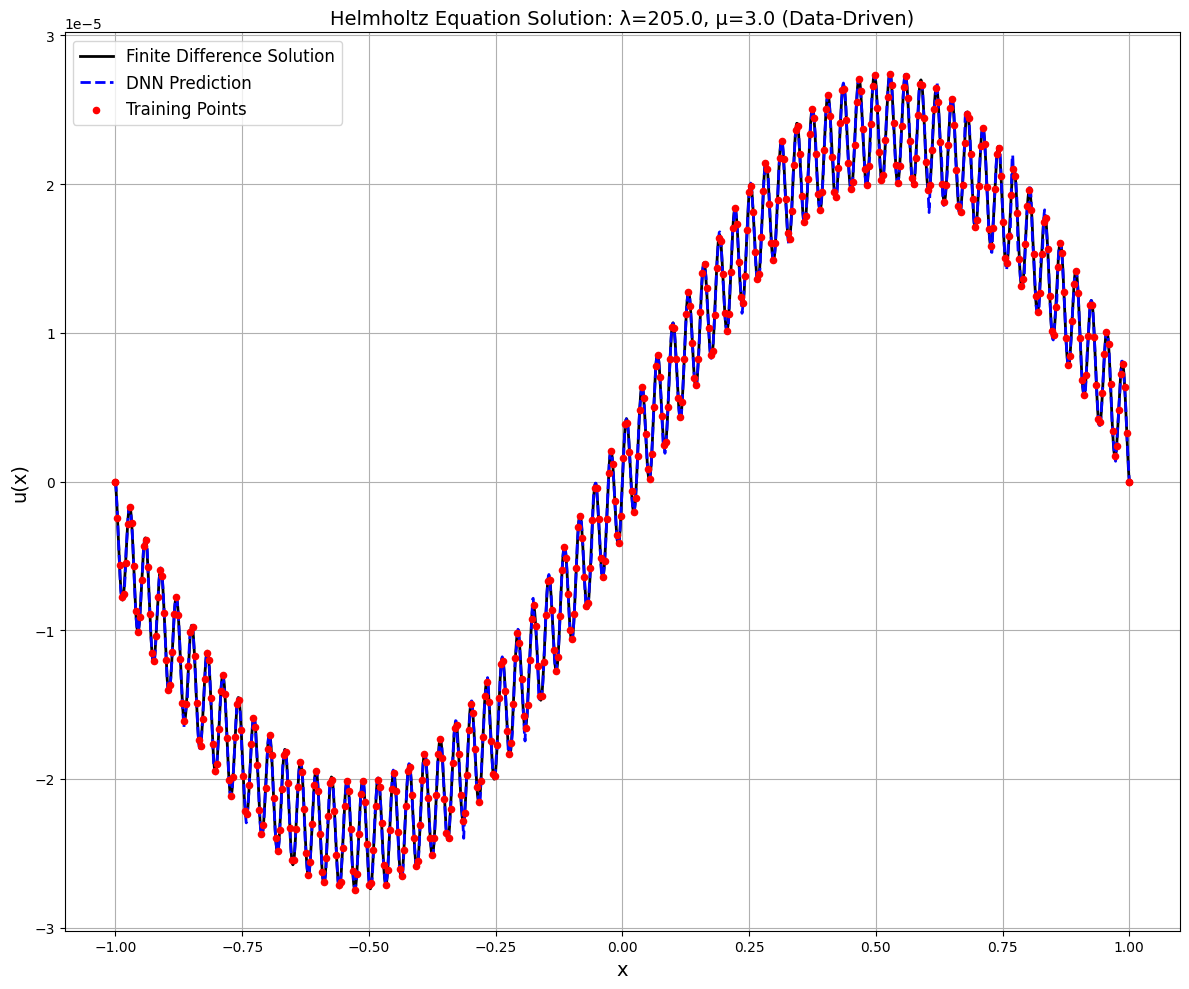

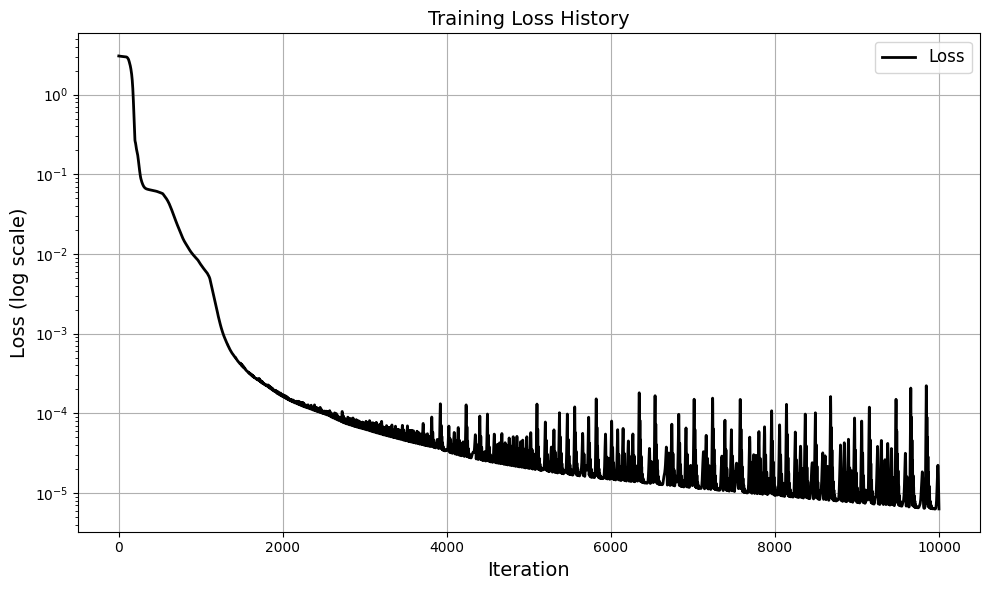

{'total_loss': [3.050164222717285,
  3.048682689666748,
  3.047236442565918,
  3.04582142829895,
  3.044440269470215,
  3.043092727661133,
  3.0417990684509277,
  3.040536880493164,
  3.039304256439209,
  3.0381019115448,
  3.0369319915771484,
  3.035792589187622,
  3.0346827507019043,
  3.033601999282837,
  3.0325584411621094,
  3.0315494537353516,
  3.0305678844451904,
  3.029614210128784,
  3.0286874771118164,
  3.027787685394287,
  3.02691388130188,
  3.0260651111602783,
  3.025270462036133,
  3.024540662765503,
  3.0237879753112793,
  3.023021697998047,
  3.0222809314727783,
  3.0215952396392822,
  3.020932197570801,
  3.0202901363372803,
  3.0196681022644043,
  3.019059419631958,
  3.0184667110443115,
  3.0178909301757812,
  3.017329216003418,
  3.016779899597168,
  3.0162439346313477,
  3.01572322845459,
  3.015212297439575,
  3.0147154331207275,
  3.014230728149414,
  3.01375412940979,
  3.0132882595062256,
  3.012827157974243,
  3.0123753547668457,
  3.0119307041168213,
  3.01

In [13]:
attention_fourier_solver=AttentionFourierSolver(
    input_dim=1,
    base_feature_dim=32,
    num_scales=8,
    N_tok=32,
    d_q=8,
    num_attn_layers=4
)
attention_fourier_solver.physical_information=False
attention_fourier_solver.if_scale_u=True    
attention_fourier_solver.fit(10000)